# Valuation of Energy Storage: Implementation of Example 3.4 of Bachouch et al. arXiv:1812.05916


From [arXiv page](https://arxiv.org/abs/1812.05916):
"We consider a commodity (gas) that has to be stored in a cave, e.g. salt domes or aquifers. The manager of such a cave aims to maximize the real options value by optimizing over a finite horizon N the dynamic decisions to inject or withdraw gas as time and market conditions evolve."


Please notice that the ReadTheDocs env has trouble rendering the math displays.
The notebook is rendered correctly at its [github location](https://github.com/rbosh/ml-adp/blob/master/doc/source/examples/energy_storage.ipynb).

$(P_t)_{t=0,\dots, T}$ the gas price, with $$P_{t+1} = \bar{p}(1-\beta) + \beta P_t + \xi_{t+1}$$ where $\bar{p} = 5$ the stationary value of the gas price, $\beta=0.5$ the rate of mean-reversal, and $\xi_{t+1}\sim \mathcal{N}(0, 0.05)$.

"The current inventory in the gas storage is denoted by $(C^\alpha_t)_t$ and depends on the manager’s decisions represented by a control process $\alpha = (\alpha_t)$ valued in $\{−1, 0, 1\}$: 
$\alpha_t = 1$ (resp. $−1$) means that she injects (resp. withdraws) gas with an injection (resp. withdrawal) rate $a_{in}(C^\alpha_t)$ (resp. $a_{out}(C^\alpha_t))$ requiring (causing) a purchase (resp. sale) of $b_{in}(C^\alpha_t) \geq a_{in}(C^\alpha_t)$ (resp. $b_{out}(C^\alpha_t) \leq a_{out}(C^\alpha_t))$, and $\alpha_t = 0$ means that she is doing nothing. The difference between $b_{in}$ and $a_{in}$ (resp. $b_{out}$ and $a_{out}$) indicates gas loss during injection/withdrawal. The evolution of the inventory is then governed by $$C^\alpha_{t+1} = C^{\alpha}_{t} + h(C^\alpha_t , \alpha_t),\quad t = 0, . . . , T − 1, \quad  C^\alpha_0 = c_0$$ where we set $h(c, a) = a_{in}(c)$ if $a=1$, $h(c,a)=-a_{out}(c)$ if $a=-1$, and $h(c,a)=0$ if $a=0$."
We set $a_{in} = 0.06 = b_{in}$ and $a_{out} = 0.25 = b_{out}$.

We have the physical inventory constraint $$C^\alpha_t \in [C_{min}, C_{max}]$$ where $C_{min} = 0$ and $C_{max} = 8$.

The time-$t$ cost (for $t< T$) of the manager is $$K_t(p, c, a) = \begin{cases} b_{in}(c)p + k c, & a=1\\ kc, & a=0\\ b_{out}(c)p + kc, & a=-1\end{cases}$$ where $k=0.01$ is the storage cost, while $$K_T(p, c) = \mu P (c_0 - c)$$ penalizes shortfall at final time below the initial level of inventory ($\mu=2$).

In [ ]:
number_of_steps = 5

stationary_price = 5.
reversal_rate = .5
storage_cost_rate = 0.01

penalty_factor = 2.
initial_inventory = 4.

a_out = 0.25
a_in = 0.06

b_out = a_out
b_in = a_in

Implementation of state transition function (state is $s_t = (p_t, c_t)$):

In [26]:
import torch
from torch import heaviside

def _choose(x, a, b):
    return (b + a) * heaviside(x, a / (a + b)) - a


class StateTransition:
    def __init__(self, stationary_price: float = 5., reversal_rate: float = 0.5,
                 a_in: float = 0.06, a_out: float = 0.25):
        self.stationary_price = stationary_price
        self.reversal_rate = reversal_rate
        self.a_in = torch.tensor([a_in])
        self.a_out = torch.tensor([a_out])

    def __call__(self, state, control, random_effect):
        gas_price = state[0]
        inventory = state[1]

        next_gas_price = (self.stationary_price * (1 - self.reversal_rate)
                          + gas_price * self.reversal_rate
                          + random_effect)
        
        next_inventory = (inventory + _choose(control, a=self.a_out, b=self.a_in))

        return next_gas_price, next_inventory


Implementation of running cost and terminal cost:

In [154]:
class Cost:
    def __init__(self, storage_cost_rate: float = 0.01, b_in: float = 0.06, b_out: float = 0.25,
                 c_min: float = 0., c_max: float = 8., range_penalty_factor: float = 1e5):
        self.storage_cost_rate = storage_cost_rate
        self.b_in = torch.tensor([b_in])
        self.b_out = torch.tensor([b_out])
        self.floor = torch.nn.ReLU()
        self.c_min = c_min; self.c_max = c_max
        self.range_penalty_factor = range_penalty_factor

    def __call__(self, state, control):
        gas_price = state[0]
        inventory = state[1]

        cost = (_choose(control, a=self.b_out, b=self.b_in) * gas_price
                + self.storage_cost_rate * inventory
                + self.range_penalty_factor * self.floor(inventory - self.c_max)
                + self.range_penalty_factor * self.floor(self.c_min - inventory))

        return cost

class TerminalCost:
    def __init__(self, penalty_factor: float = 2., initial_inventory: float = 4.,
                 c_min: float = 0., c_max: float = 8., range_penalty_factor: float = 1e5):
        self.penalty_factor = penalty_factor
        self.initial_inventory = initial_inventory
        self.floor = torch.nn.ReLU()
        self.c_min = c_min
        self.c_max = c_max
        self.range_penalty_factor = range_penalty_factor

    def __call__(self, state):
        gas_price = state[0]
        inventory = state[1]
        return (self.penalty_factor * gas_price * self.floor(self.initial_inventory - inventory)
                + self.range_penalty_factor * self.floor(inventory - self.c_max)
                + self.range_penalty_factor * self.floor(self.c_min - inventory))  


Crate CostToGo object of appropriate length and set state and cost functions:

In [156]:
from ml_adp.cost import CostToGo

cost_to_go = CostToGo.from_number_of_steps(number_of_steps)

cost_to_go.state_functions[:-1] = StateTransition(stationary_price, reversal_rate, a_in, a_out)
cost_to_go.cost_functions[:-1] = Cost(storage_cost_rate, b_in, b_out)
cost_to_go.cost_functions[-1] = TerminalCost(penalty_factor, initial_inventory)

cost_to_go


CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                                  None                 Cost(-)        
    1     StateTra...on(-)             None                 Cost(-)        
    2     StateTra...on(-)             None                 Cost(-)        
    3     StateTra...on(-)             None                 Cost(-)        
    4     StateTra...on(-)             None                 Cost(-)        
    5     StateTra...on(-)             None             TerminalCost(-)    
   (6)          None                                                       
)

Choose neural network based classifier control functions:
FFN with softmax activation, before choosing the action according to argmax.

In [163]:
from ml_adp.nn import FFN

class Control(torch.nn.Module):
    def __init__(self, hidden_size=(20, 20)):
        super().__init__()

        self.control_values = torch.tensor([[-1.], [0.], [1.]])
        proba_net_size = (2, *hidden_size, 3)
        self.proba_net = FFN.from_config(proba_net_size, output_activation=torch.nn.Softmax(dim=1))

    def probas(self, state):
        gas_price = state[0]
        inventory = state[1]

        return self.proba_net(torch.cat([gas_price, inventory], dim=1))

    def forward(self, state):
        idx = torch.argmax(self.probas(state), dim=1)
        return self.control_values[idx]
    

Set control functions:

In [164]:
for i in range(len(cost_to_go) - 1):
    cost_to_go.control_functions[i] = Control()

Inspect the object:

In [165]:
cost_to_go

CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                             Control(train)            Cost(-)        
    1     StateTra...on(-)        Control(train)            Cost(-)        
    2     StateTra...on(-)        Control(train)            Cost(-)        
    3     StateTra...on(-)        Control(train)            Cost(-)        
    4     StateTra...on(-)        Control(train)            Cost(-)        
    5     StateTra...on(-)             None             TerminalCost(-)    
   (6)          None                                                       
)

Create training state ($(\tilde{P}_t, \tilde{C}_t)$) and random effects ($(\xi_{t+1})$) samplers:

In [166]:
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

training_state_sampler = Uniform(torch.tensor(0.), torch.tensor(8.)) 
price_vol_sampler = Normal(torch.tensor(0.), torch.tensor(0.05))

Perform backward-iterative ADP optimization following "ClassifPI algorithm" from Bachouch et al: arXiv:1812.05916

In [168]:
from tqdm import tqdm

sim_size = 5000

cost_to_go.train()

for time in reversed(range(cost_to_go.number_of_steps())):
    objective = cost_to_go[time:]

    control = objective.control_functions[0] 
    print(f"Time {time} objective:")
    print(objective)
    print(75 * "%")

    optimizer = torch.optim.Adam(params=control.parameters())
   
    gradient_descent_iterations = tqdm(range(300), ascii=' =')
    for iteration in gradient_descent_iterations:
        training_state = training_state_sampler.sample((2, sim_size, 1))
        rand_effs = price_vol_sampler.sample((objective.number_of_steps(), sim_size, 1))

        probas = control.probas(training_state)

        loss = 0.
        for l in range(probas.size(1)):
            control_value = control.control_values[l]
            objective.control_functions[0] = lambda _: control_value.unsqueeze(0)

            loss = loss + (objective(training_state, rand_effs) * probas[:, [l]]).mean()
        
        gradient_descent_iterations.set_description(
            f"Time {time} Loss: {loss:9.4f}"
        )

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    control.eval()



Time 4 objective:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                             Control(train)            Cost(-)        
    1     StateTra...on(-)             None             TerminalCost(-)    
   (2)          None                                                       
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 4 Loss:    8.5497: 100%|==========| 300/300 [00:06<00:00, 43.66it/s]


Time 3 objective:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                             Control(train)            Cost(-)        
    1     StateTra...on(-)        Control(eval)             Cost(-)        
    2     StateTra...on(-)             None             TerminalCost(-)    
   (3)          None                                                       
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 3 Loss:    8.3260: 100%|==========| 300/300 [00:07<00:00, 37.65it/s]


Time 2 objective:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                             Control(train)            Cost(-)        
    1     StateTra...on(-)        Control(eval)             Cost(-)        
    2     StateTra...on(-)        Control(eval)             Cost(-)        
    3     StateTra...on(-)             None             TerminalCost(-)    
   (4)          None                                                       
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 2 Loss:    7.7212: 100%|==========| 300/300 [00:09<00:00, 32.08it/s]


Time 1 objective:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                             Control(train)            Cost(-)        
    1     StateTra...on(-)        Control(eval)             Cost(-)        
    2     StateTra...on(-)        Control(eval)             Cost(-)        
    3     StateTra...on(-)        Control(eval)             Cost(-)        
    4     StateTra...on(-)             None             TerminalCost(-)    
   (5)          None                                                       
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 1 Loss:    7.7812: 100%|==========| 300/300 [00:11<00:00, 27.00it/s]


Time 0 objective:
CostToGo(
 time |      state_func      |     control_func     |      cost_func       
    0                             Control(train)            Cost(-)        
    1     StateTra...on(-)        Control(eval)             Cost(-)        
    2     StateTra...on(-)        Control(eval)             Cost(-)        
    3     StateTra...on(-)        Control(eval)             Cost(-)        
    4     StateTra...on(-)        Control(eval)             Cost(-)        
    5     StateTra...on(-)             None             TerminalCost(-)    
   (6)          None                                                       
)
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


Time 0 Loss:    6.9435: 100%|==========| 300/300 [00:14<00:00, 20.68it/s]


Plot policies versus state using color-map scatter plot:

In [238]:
gas_prices = torch.arange(3.5, 6.0, 0.05)
inventories = torch.arange(3., 5.0, 0.05)

grid = torch.cartesian_prod(gas_prices, inventories)

x, y = grid.tensor_split(2, dim=1)

control = cost_to_go.control_functions[0]
c = control((x, y))

In the following plots, yellow indicates 1 (injection) and purple indicates -1 (withdrawal).

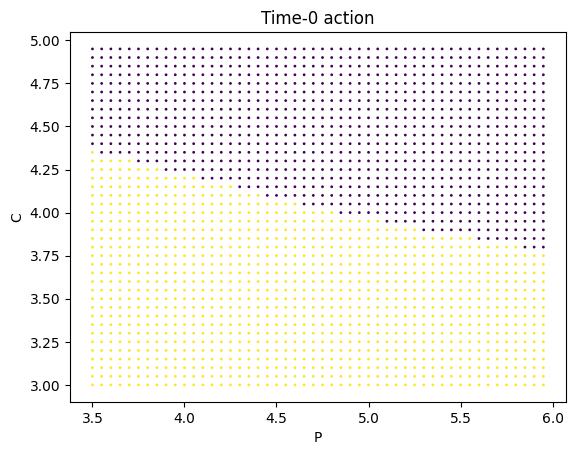

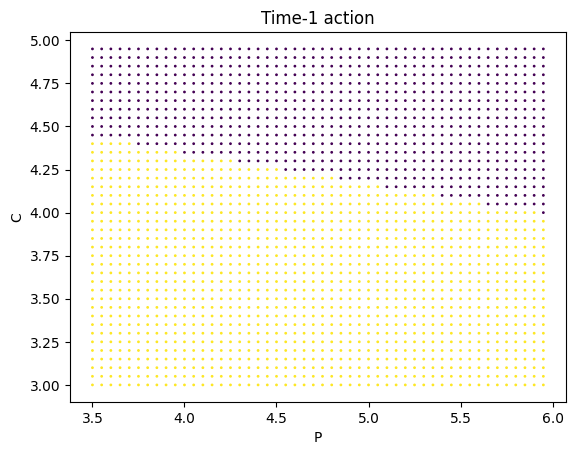

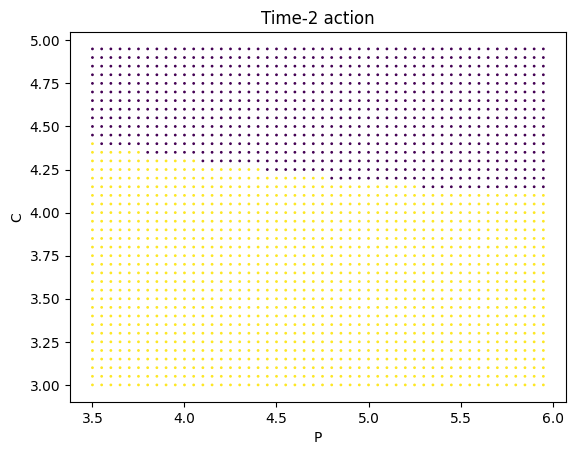

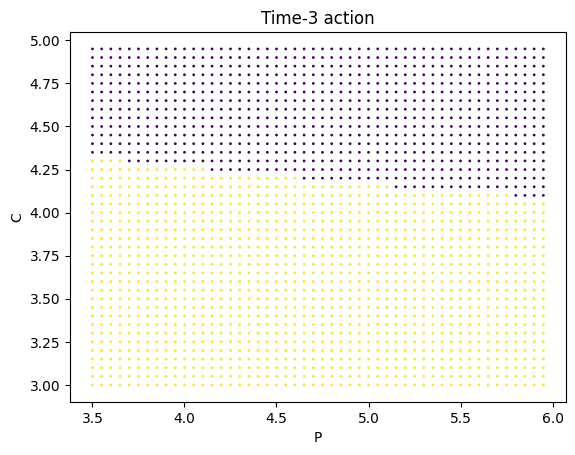

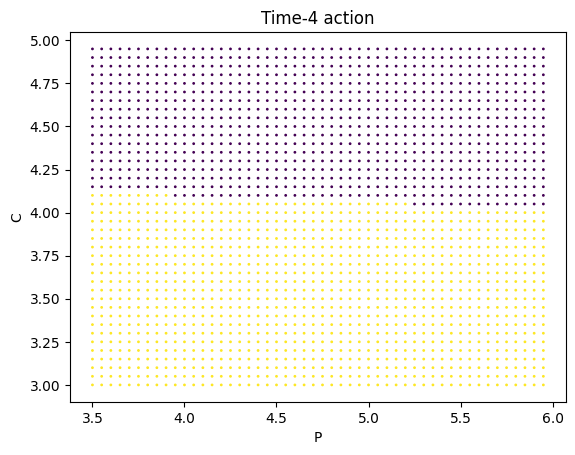

In [246]:
import matplotlib.pyplot as plt

for time, control_function in enumerate(cost_to_go.control_functions[:-1]):
    c = control_function((x, y))
    plt.scatter(x, y, s=1., c=c)
    plt.xlabel('P')
    plt.ylabel('C')
    plt.title(f'Time-{time} action')
    plt.show()